In [101]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import to_categorical
import os
import shutil
from glob import glob
import cv2
import numpy as np
from matplotlib import pylab as plt
import tensorflow as tf

In [102]:
# def load_train(batch_size):
#   path1=sorted(glob('../input/data_set/data_set/train/*'))
#   path2=sorted(glob('../input/data_set/data_set/label/*'))
#   n_batches=int(len(path1)/batch_size)
  
#   for i in range(n_batches):
#     batch1=path1[i*batch_size:(i+1)*batch_size]
#     batch2=path2[i*batch_size:(i+1)*batch_size]
#     train_images=[]
#     train_labels=[]
#     for filename1,filename2 in zip(batch1,batch2):
#       img1=cv2.imread(filename1,-1)
#       img2=cv2.imread(filename2,-1)
#       img1=img1[...,::-1]
#       img1=img1.reshape(512,512,1)
#       img2=img2[...,::-1]
#       img2=img2.reshape(512,512,1)
#       train_images.append(img1)
#       train_labels.append(img2)
  
#     train_images=np.array(train_images)/255
#     train_labels=np.array(train_labels)/255
  
#     yield train_images,train_labels  

In [103]:
def load_train():
  path1=sorted(glob('../input/segmentation/data_set/data_set/train/*'))
  path2=sorted(glob('../input/segmentation/data_set/data_set/label/*'))
  
  train_images=[]
  train_labels=[]
  for filename1,filename2 in zip(path1,path2):
    img1=cv2.imread(filename1,-1)
    img2=cv2.imread(filename2,-1)
    img1=img1[...,::-1]
    img1=img1.reshape(512,512,1)
    img2=img2[...,::-1]
    img2=img2.reshape(512,512,1)
    train_images.append(img1)
    train_labels.append(img2)
    
  train_images=np.array(train_images)/255
  train_labels=(np.array(train_labels)/255).astype('uint8')
  
  return train_images,train_labels

In [104]:
train_images,train_labels=load_train()
#train_labels=to_categorical(train_labels,2)
print(train_images.shape)
print(train_labels.shape)
print(type(train_images[0][1][300][0]))
print(train_images[0][1][300][0])
print(type(train_labels[0][1][300][0]))
print(train_labels[0][1][300][0])

(30, 512, 512, 1)
(30, 512, 512, 1)
<class 'numpy.float64'>
0.34509803921568627
<class 'numpy.uint8'>
0


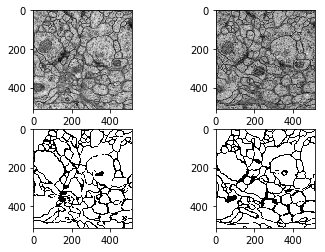

In [105]:
for i in range(2):
    plt.subplot(2,2,i+1)
    plt.imshow(train_images[i].reshape(512,512),cmap='gray')
    plt.subplot(2,2,i+3)
    plt.imshow(train_labels[i,:,:,0],cmap='gray')

In [106]:
def load_data(batch_size):
  path=glob('../input/segmentation/data_set/data_set/test/*')
  batch=np.random.choice(path,size=batch_size)
  test_images=[]
  for filename in batch:
    img=cv2.imread(filename,-1)
    img=img[...,::-1]
    img=img.reshape(512,512,1)
    test_images.append(img)
  test_images=np.array(test_images)/255
  
  return test_images

In [107]:
test_images=load_data(2)
print(test_images.shape)
print(type(test_images[0][0][0][0]))

(2, 512, 512, 1)
<class 'numpy.float64'>


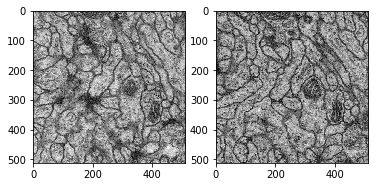

In [108]:
fig=plt.figure()
for i in range(2):
  plt.subplot(1,2,i+1)
  plt.imshow(test_images[i].reshape(512,512),cmap='gray')

In [109]:
import keras.layers as layers
from keras.models import Model
from keras.optimizers import Adam
import time
from keras import backend as K
from keras.metrics import categorical_accuracy

In [110]:
class Unet():
  def __init__(self,img_rows=512,img_cols=512):
    self.img_rows=img_rows
    self.img_cols=img_cols
    self.df=64
    self.uf=64
    self.img_shape=(self.img_rows,self.img_cols,1)
    
  def build_unet(self):
    def conv2d(layer_input,filters,dropout_rate=0):
      d=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu',
                      kernel_initializer='he_normal')(layer_input)
      if dropout_rate:
        d=layers.Dropout(dropout_rate)(d)
      return d
    
    def deconv2d(layer_input,skip_input,filters):
      u=layers.UpSampling2D((2,2))(layer_input)
      u=layers.Conv2D(filters,kernel_size=(2,2),strides=(1,1),padding='same',activation='relu',
                      kernel_initializer='he_normal')(u)
      u=layers.Concatenate()([u,skip_input])
      return u
    
    inputs=layers.Input(shape=self.img_shape)
    
    conv1=conv2d(inputs,self.df)
    conv1=conv2d(conv1,self.df)
    pool1=layers.MaxPooling2D(pool_size=(2,2))(conv1)
    
    conv2=conv2d(pool1,self.df*2)
    conv2=conv2d(conv2,self.df*2)
    pool2=layers.MaxPooling2D(pool_size=(2,2))(conv2)
    
    conv3=conv2d(pool2,self.df*4)
    conv3=conv2d(conv3,self.df*4)
    pool3=layers.MaxPooling2D(pool_size=(2,2))(conv3)
    
    conv4=conv2d(pool3,self.df*8)
    conv4=conv2d(conv4,self.df*8,dropout_rate=0.5)
    pool4=layers.MaxPooling2D(pool_size=(2,2))(conv4)
    
    conv5=conv2d(pool4,self.df*16)
    conv5=conv2d(conv5,self.df*16,dropout_rate=0.5)
    
    up6=deconv2d(conv5,conv4,self.uf*8)
    conv6=conv2d(up6,self.df*8)
    conv6=conv2d(conv6,self.df*8)
    
    up7=deconv2d(conv6,conv3,self.uf*4)
    conv7=conv2d(up7,self.uf*4)
    conv7=conv2d(conv7,self.uf*4)
    
    up8=deconv2d(conv7,conv2,self.uf*2)
    conv8=conv2d(up8,self.uf*2)
    conv8=conv2d(conv8,self.uf*2)
    
    up9=deconv2d(conv8,conv1,self.uf)
    conv9=conv2d(up9,self.uf)
    conv9=conv2d(conv9,self.uf)
    
    #outputs=layers.Conv2D(1,kernel_size=(1,1),strides=(1,1),activation='sigmoid')(conv9)
    outputs=layers.Conv2D(2,kernel_size=(1,1),strides=(1,1),activation='softmax')(conv9)
    model=Model(inputs=inputs,outputs=outputs)
    
    return model
    

In [111]:
a=Unet()
unet=a.build_unet()
unet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_139 (Conv2D)             (None, 512, 512, 64) 640         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_140 (Conv2D)             (None, 512, 512, 64) 36928       conv2d_139[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_25 (MaxPooling2D) (None, 256, 256, 64) 0           conv2d_140[0][0]                 
__________________________________________________________________________________________________
conv2d_141

In [112]:
# def dice_coef_loss(y_true,y_pred):
#   y_true_f=K.flatten(y_true)
#   y_pred_f=K.flatten(y_pred)
#   intersection=K.sum(y_true_f*y_pred_f)
#   return 1-(2*intersection)/(K.sum(y_true_f*y_true_f)+K.sum(y_pred_f*y_pred_f))

In [113]:
train_labels=to_categorical(train_labels,2)

In [114]:
unet.compile(loss='categorical_crossentropy',
             optimizer=Adam(1e-4),
             metrics=['categorical_accuracy'])
unet.fit(train_images,train_labels,validation_split=0.1,batch_size=3,epochs=20,verbose=1,shuffle=True)


Train on 27 samples, validate on 3 samples
Epoch 1/20
27/27 [==============================] - 12s 454ms/step - loss: 0.6130 - categorical_accuracy: 0.7218 - val_loss: 0.4632 - val_categorical_accuracy: 0.7665
Epoch 2/20
27/27 [==============================] - 4s 154ms/step - loss: 0.4251 - categorical_accuracy: 0.7895 - val_loss: 0.4425 - val_categorical_accuracy: 0.7681
Epoch 3/20
27/27 [==============================] - 4s 154ms/step - loss: 0.3992 - categorical_accuracy: 0.8102 - val_loss: 0.4473 - val_categorical_accuracy: 0.7680
Epoch 4/20
27/27 [==============================] - 4s 154ms/step - loss: 0.3589 - categorical_accuracy: 0.8228 - val_loss: 0.4546 - val_categorical_accuracy: 0.7718
Epoch 5/20
27/27 [==============================] - 4s 154ms/step - loss: 0.3303 - categorical_accuracy: 0.8441 - val_loss: 0.3300 - val_categorical_accuracy: 0.8386
Epoch 6/20
27/27 [==============================] - 4s 154ms/step - loss: 0.3236 - categorical_accuracy: 0.8492 - val_loss: 0.

(2, 512, 512, 1)
<class 'numpy.float32'>


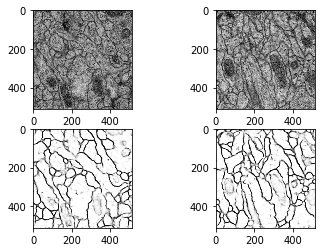

In [117]:
test_images=load_data(2)
print(test_images.shape)
result=unet.predict(test_images)
print(type(result[0][0][0][0]))
fig=plt.figure()
for i in range(2):
    plt.subplot(2,2,i+1)
    plt.imshow(test_images[i].reshape(512,512),cmap='gray')
    plt.subplot(2,2,i+3)
    plt.imshow(result[i,:,:,1],cmap='gray')

In [118]:
!nvidia-smi

Tue May 28 08:18:07 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    41W / 250W |  15607MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  